In [1]:
import numpy as np
import scipy
from random import choice

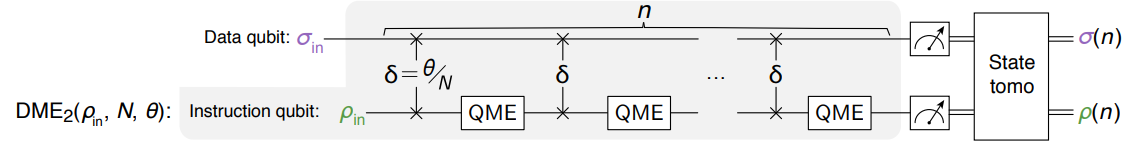

Define partial trace and Hermitian conjugate function

Pauli matrices etc

In [2]:
X = np.array([[0,1],
              [1,0]])

Y = np.array([[0,-1j],
              [1j,0]])

Z = np.array([[1,0],
              [0,-1]])

I = np.array([[1,0],
              [0,1]])

swap = np.array([[1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]])

XX = np.kron(X,X)
YY = np.kron(Y,Y)
ZZ = np.kron(Z,Z)


In [3]:
def ptrace(matrix,index=1,n1=2,n2=2):
    # Partial trace function for density matrices.
    current_tensor=matrix.reshape([n1, n2, n1, n2])
    if index == 1:
        return np.trace(current_tensor, axis1=1, axis2=3)
    elif index == 2:
        return np.trace(current_tensor, axis1=0, axis2=2)
    else:
        print('Error')

def dagger(u):
    return np.asarray(np.matrix(u).H)

from scipy.linalg import sqrtm
def fidelity(rho1, rho2):
    # Compute the square root of the first density matrix
    sqrt_rho1 = sqrtm(rho1)
    # Compute the matrix product of sqrt(rho1) * rho2 * sqrt(rho1)
    product = sqrt_rho1 @ rho2 @ sqrt_rho1    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)    
    return np.real(np.trace(sqrt_product)) ** 2

def measure(psi, projectors=None):
    if projectors is None:
        # Default to computational basis projectors for a qubit
        projectors = [np.array([[1, 0], [0, 0]]),  # |0⟩⟨0|
                      np.array([[0, 0], [0, 1]])]  # |1⟩⟨1|
    
    probs = [np.vdot(psi, P @ psi).real for P in projectors]
    outcome = choice(len(projectors), p=probs)
    return outcome



Define the qubit initial density matrices

In [4]:
ket_plus = np.array([[1/np.sqrt(2)],[1/np.sqrt(2)]])
rho_plus = np.outer(ket_plus,ket_plus.conj().T)

ket_0 = np.array([[1],[0]])
rho_0 = np.outer(ket_0,ket_0.conj().T)

t = 0.2

Define the unitaries

In [5]:
def U_rho(t,rho):
    return scipy.linalg.expm(-1j*t*rho)

In [6]:
# Native SWAP
def U(t):
    return scipy.linalg.expm(-1j*t*swap)
np.round(U(t) @ np.kron(rho_0,rho_plus) @ dagger (U(t)),3)

array([[0.5 +0.j   , 0.48-0.097j, 0.02+0.097j, 0.  +0.j   ],
       [0.48+0.097j, 0.48+0.j   , 0.  +0.097j, 0.  +0.j   ],
       [0.02-0.097j, 0.  -0.097j, 0.02+0.j   , 0.  +0.j   ],
       [0.  +0.j   , 0.  +0.j   , 0.  +0.j   , 0.  +0.j   ]])

In [7]:
II = np.kron(I,I)
IX = np.kron(I,X)
def qme(state,u):
    gate = choice([II,IX])
    return gate @ u @ state @ dagger(u) @ dagger(gate)

In [8]:
num_tomo = 100
num_muq = 100
from matplotlib import cm
color = cm.rainbow(np.linspace(1, 0, num_muq))



In [9]:
initial_state = np.kron(rho_0,rho_plus)
average_states =  []


for muq in range(1,num_muq):
    _t = t/muq
    u = U(_t)
    states = []

    # Repeat the n randomized muq steps for tomography
    for j in range(num_tomo):
        
        # Do n muq, where n go from 0 to N
        state = initial_state
        for i in range(muq):
            state = qme(state,u)
        states.append(state)
    
    average_states.append(np.mean(states,axis=0))


In [10]:
dme_state = np.kron(rho_0,rho_plus)
dme_W_states = []
# Normal DME
for muq in range(1,num_muq):
    _t = t/muq
    u = U(_t)
    dme_state = np.kron(rho_0,rho_plus)
    for i in range(muq):
        dme_state = u @ dme_state @ dagger(u)
        rho_W = ptrace(dme_state)
        dme_state = np.kron(rho_W,rho_plus)
    dme_W_states.append(rho_W)

In [11]:
_U = U_rho(t,rho_plus)
expected_state = _U @ rho_0 @ dagger(_U)
print(np.round(expected_state,3))

[[ 0.99+0.j    -0.  +0.099j]
 [-0.  -0.099j  0.01-0.j   ]]


In [12]:
norm_dme = [np.linalg.norm(expected_state-state) for state in dme_W_states]
norm = [np.linalg.norm(expected_state-ptrace(state,1)) for state in average_states]


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": True, # Remove this line if your code doesn't run/ take too long
    "font.family": "serif",
    "figure.dpi": 100,
    "font.size": 14
})

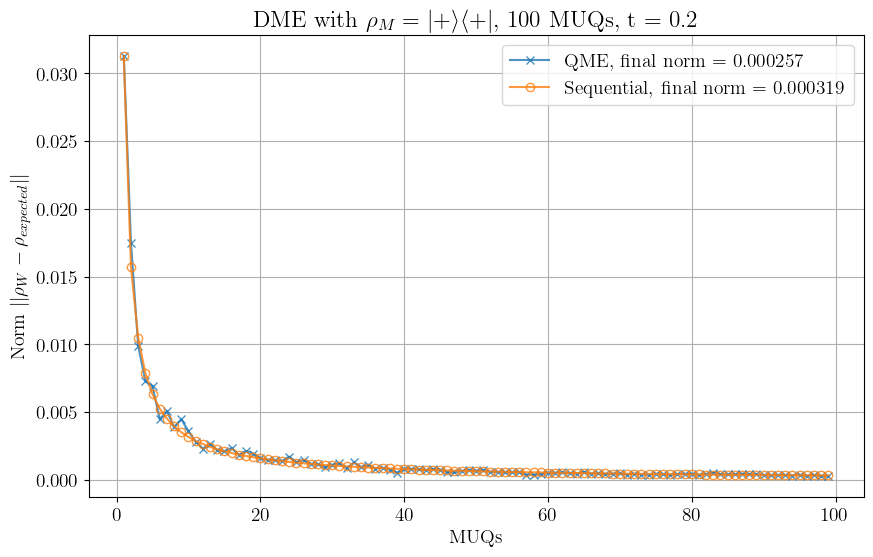

In [15]:
plt.plot(range(1,num_muq),norm,marker='x',alpha=0.8,label=f'QME, final norm = {float('%.3g' % norm[-1])}')
plt.plot(range(1,num_muq),norm_dme,marker='o',markerfacecolor='none',alpha=0.8,label=f'Sequential, final norm = {float('%.3g' % norm_dme[-1])}')
plt.xlabel('MUQs')
plt.ylabel(r'Norm $|| \rho_W - \rho_{expected} ||$')
plt.grid()
plt.title(r'DME with $\rho_M = |+\rangle \langle +|$, '+f'{num_muq} MUQs, t = {t}')
plt.legend()